<a href="https://colab.research.google.com/github/raz0208/ModernBERT/blob/main/Agritech_Pest_Prediction_SARIMAX_TSA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Time Series Analysis For Agritech Pest Prediction

### **SARIMA** Model Implementation:

In [2]:
# # Uninstall potentially conflicting versions first
# !pip uninstall -y pmdarima numpy

# # Install the latest NumPy 1.x version (e.g., 1.26.4)
# !pip install numpy==1.26.4

# # Now install pmdarima (hopefully it links against NumPy 1.26.4)
# # Use --no-cache-dir just to be safe
# !pip install --no-cache-dir pmdarima==2.0.4

In [3]:
# import required libaraies
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from pmdarima import auto_arima
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [4]:
# Load datasets
FeatureExtracted_df = pd.read_csv('/content/FeatureExtracted_dataset.csv')

In [5]:
# Display basic info for  datasets FeatureExtracted_dataset
print(FeatureExtracted_df.head(), '\n')
print(FeatureExtracted_df.info())

         Date      Time  Number of Insects  New Catches  Event   Location  \
0  2024-07-06  06:01:00                0.0          0.0      0  Cicalino1   
1  2024-07-07  06:04:00                0.0          0.0      0  Cicalino1   
2  2024-07-08  06:03:00                0.0          0.0      0  Cicalino1   
3  2024-07-09  06:05:00                0.0          0.0      1  Cicalino1   
4  2024-07-10  06:03:00                0.0          0.0      0  Cicalino1   

   Average Temperature  Temp_low  Temp_high  Average Humidity  ...  \
0                13.91      13.6       14.4             97.65  ...   
1                20.78      20.1       21.2             83.49  ...   
2                19.03      18.7       19.5             96.87  ...   
3                15.33      15.0       15.7             82.29  ...   
4                15.48      15.0       16.0             87.12  ...   

   Day Max_temp  Day Avg_Humidity  Temp_change  Year  Month  Day  Weekday  \
0          30.6             72.25      

In [6]:
# Convert 'Date' column to datetime format
FeatureExtracted_df['Date'] = pd.to_datetime(FeatureExtracted_df['Date'])

In [7]:
# Drop some columns
FeatureExtracted_df.drop(['Lag_1', 'Lag_2', 'Lag_3'], axis=1, inplace=True)

# Group and aggregate
aggregated_df = FeatureExtracted_df.groupby('Date').agg({
    'Number of Insects': 'sum',
    'New Catches': 'sum',
    'Event': 'max',
    'Average Temperature': 'mean',
    'Temp_low': 'mean',
    'Temp_high': 'mean',
    'Average Humidity': 'mean',
    'Day Avg_temp': 'mean',
    'Day Min_temp': 'mean',
    'Day Max_temp': 'mean',
    'Day Avg_Humidity': 'mean',
    'Temp_change': 'mean',
    'Year': 'first',
    'Month': 'first',
    'Day': 'first',
    'Weekday': 'first',
    # 'Lag_1': 'mean',
    # 'Lag_2': 'mean',
    # 'Lag_3': 'mean'
}).reset_index()

print(aggregated_df.head(10))

# # save to csv file
# aggregated_df.to_csv('aggregated_dataset.csv', index=False)

        Date  Number of Insects  New Catches  Event  Average Temperature  \
0 2024-07-05                0.0          0.0      0              16.6900   
1 2024-07-06                0.0          0.0      0              16.5225   
2 2024-07-07                0.0          0.0      0              19.8125   
3 2024-07-08                0.0          0.0      1              17.7825   
4 2024-07-09                0.0          0.0      1              18.4850   
5 2024-07-10                0.0          0.0      0              15.4800   
6 2024-07-11                0.0          0.0      1              15.8400   
7 2024-07-12                0.0          0.0      0              16.6350   
8 2024-07-13                0.0          0.0      0              18.9650   
9 2024-07-14                1.0          1.0      0              17.1300   

   Temp_low  Temp_high  Average Humidity  Day Avg_temp  Day Min_temp  \
0    16.300     17.000           89.4800       27.1400        15.700   
1    16.175     16.

In [8]:
# Convert "Date" to datetime format
aggregated_df["Date"] = pd.to_datetime(aggregated_df["Date"])

# Set "Date" as the index
aggregated_df.set_index("Date", inplace=True)

# Check for Nan_Value
print(aggregated_df.isna().sum())

Number of Insects      0
New Catches            0
Event                  0
Average Temperature    0
Temp_low               0
Temp_high              0
Average Humidity       0
Day Avg_temp           0
Day Min_temp           0
Day Max_temp           0
Day Avg_Humidity       0
Temp_change            0
Year                   0
Month                  0
Day                    0
Weekday                0
dtype: int64


### Visualization trends

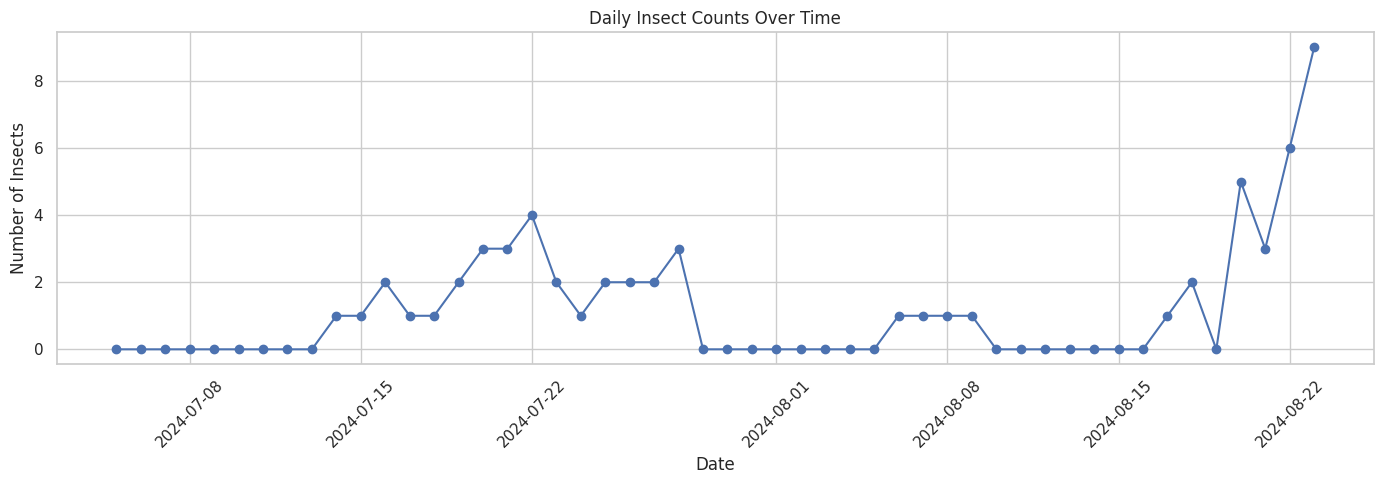

In [9]:
##-- ### Visualization trends ### --##

# Set plot style
sns.set(style="whitegrid")

# Plot the time series
plt.figure(figsize=(14, 5))
plt.plot(aggregated_df.index, aggregated_df['Number of Insects'], marker='o', linestyle='-')
plt.title('Daily Insect Counts Over Time')
plt.xlabel('Date')
plt.ylabel('Number of Insects')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

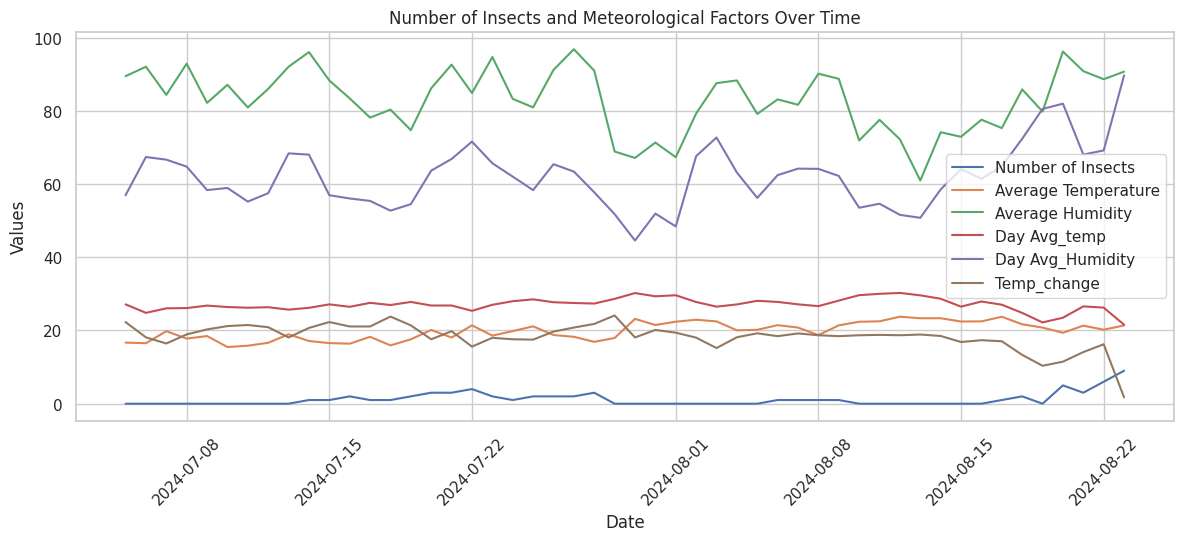

In [10]:
# Features to plot
features_to_plot = [
    'Number of Insects',
    'Average Temperature',
    'Average Humidity',
    'Day Avg_temp',
    'Day Avg_Humidity',
    'Temp_change'
]

# Plotting
plt.figure(figsize=(12, 5))
for feature in features_to_plot:
    plt.plot(aggregated_df.index, aggregated_df[feature], label=feature)

plt.title("Number of Insects and Meteorological Factors Over Time")
plt.xlabel("Date")
plt.ylabel("Values")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.xticks(rotation=45)
plt.show()

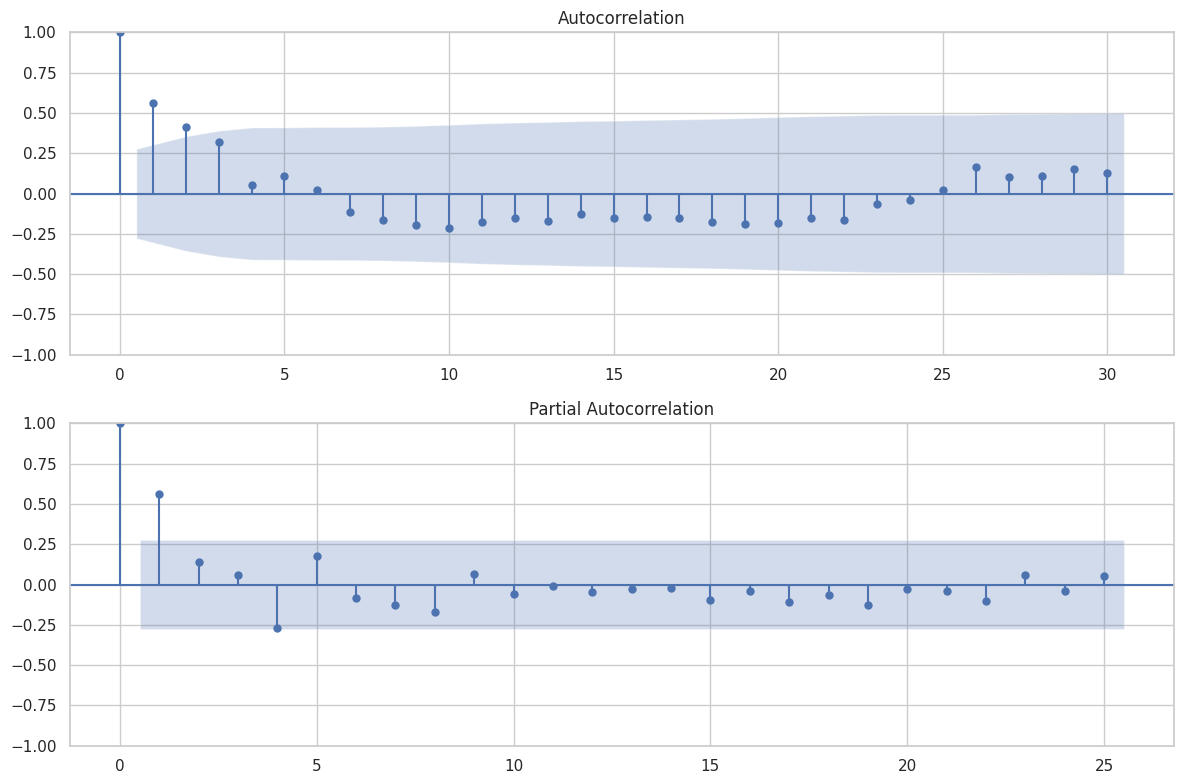

In [11]:
# Plot ACF and PACF to examine autocorrelation
fig, ax = plt.subplots(2, 1, figsize=(12, 8))
plot_acf(aggregated_df['Number of Insects'], lags=30, ax=ax[0])
plot_pacf(aggregated_df['Number of Insects'], lags=25, ax=ax[1])
plt.tight_layout()
plt.show()

### Check for Stationarity (ADF Test)

ADF Statistic: -1.7530607202128317
p-value: 0.4040019312158851
# Lags Used: 7
# Observations: 42
Critical Values:
   1%: -3.596635636000432
   5%: -2.933297331821618
   10%: -2.6049909750566895
⚠️ Series is not stationary (p >= 0.05) 



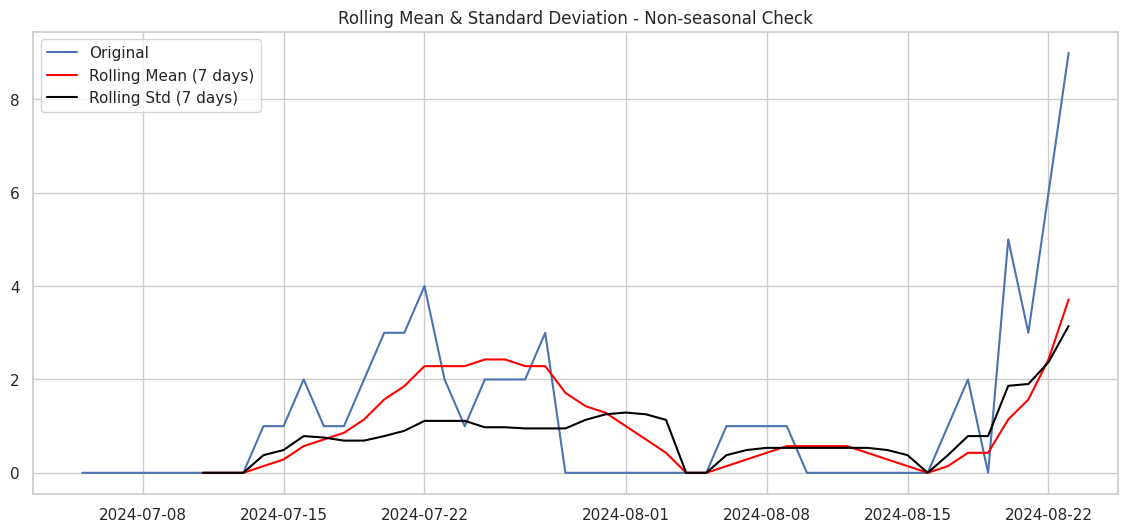

In [12]:
# Perform Augmented Dickey-Fuller (ADF) test to check for stationarity
def check_stationarity(series):
    adf_result = adfuller(series.dropna())

    result = {
        "ADF Statistic": adf_result[0],
        "p-value": adf_result[1],
        "# Lags Used": adf_result[2],
        "# Observations": adf_result[3],
        "Critical Values": adf_result[4]
    }

    # Interpretation
    result["Stationary"] = adf_result[1] < 0.05

    print("ADF Statistic:", result["ADF Statistic"])
    print("p-value:", result["p-value"])
    print("# Lags Used:", result["# Lags Used"])
    print("# Observations:", result["# Observations"])
    print("Critical Values:")
    for key, value in result["Critical Values"].items():
        print(f"   {key}: {value}")

    if result["Stationary"]:
        print("✅ Series is stationary (p < 0.05)")
    else:
        print("⚠️ Series is not stationary (p >= 0.05)", "\n")

    # Plot rolling mean and std
    rolling_mean = series.rolling(window=7).mean()
    rolling_std = series.rolling(window=7).std()

    plt.figure(figsize=(14,6))
    plt.plot(series, label='Original')
    plt.plot(rolling_mean, label='Rolling Mean (7 days)', color='red')
    plt.plot(rolling_std, label='Rolling Std (7 days)', color='black')
    plt.legend()
    plt.title("Rolling Mean & Standard Deviation - Non-seasonal Check")
    plt.show()

    #return result

check_stationarity(aggregated_df['Number of Insects'])

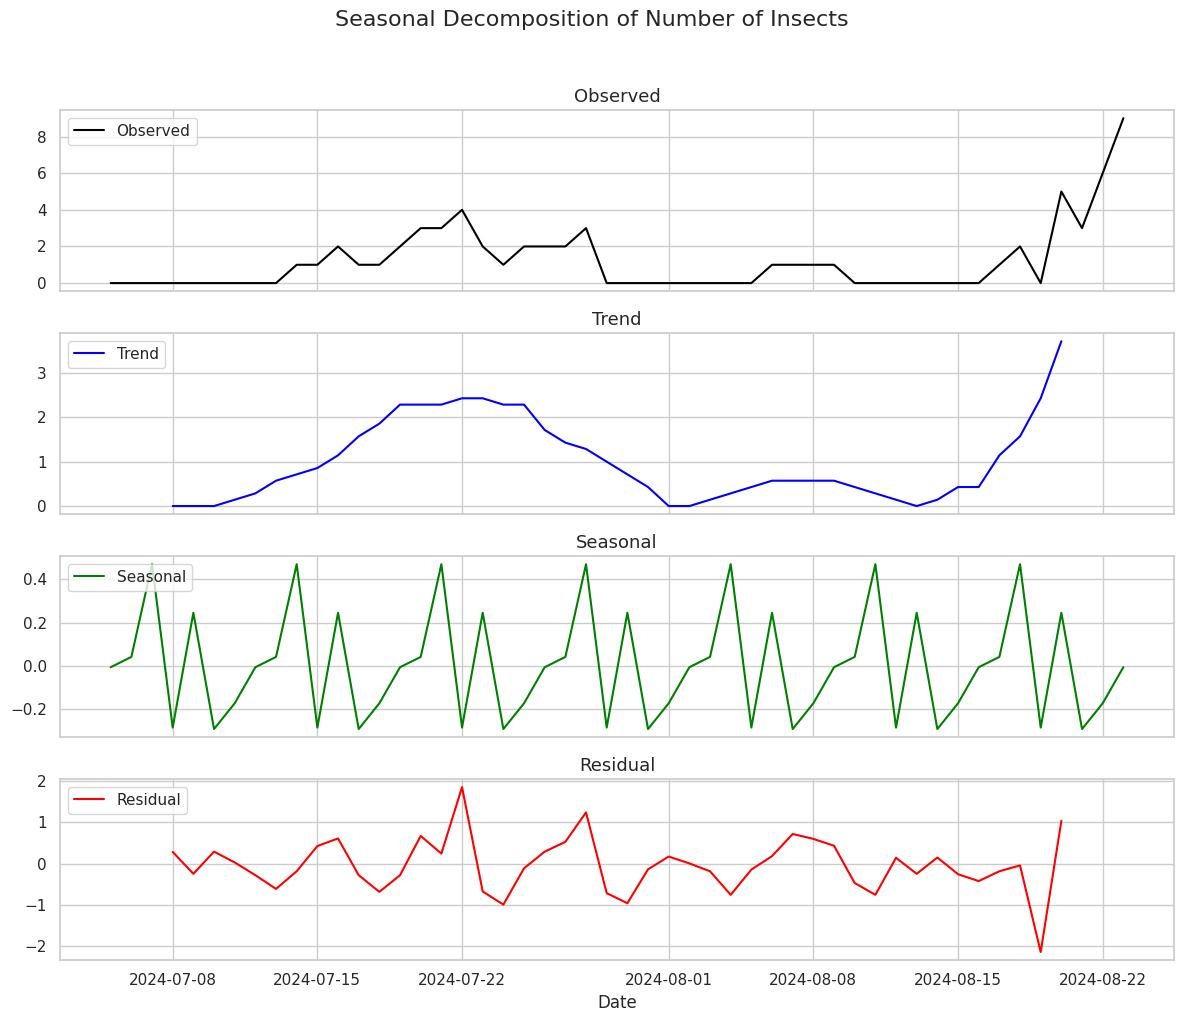

In [13]:
from statsmodels.tsa.seasonal import seasonal_decompose

insects_series = aggregated_df['Number of Insects']

# Set seaborn style for better aesthetics
sns.set(style="whitegrid")

# Seasonal decomposition
decomposition = seasonal_decompose(insects_series, model='additive', period=7)  # Weekly seasonality

# Extract components
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

# Create subplots
fig, axs = plt.subplots(4, 1, figsize=(12, 10), sharex=True)

# Plot original series
axs[0].plot(insects_series, label='Observed', color='black')
axs[0].set_title('Observed', fontsize=13)
axs[0].legend(loc='upper left')

# Plot trend
axs[1].plot(trend, label='Trend', color='blue')
axs[1].set_title('Trend', fontsize=13)
axs[1].legend(loc='upper left')

# Plot seasonal
axs[2].plot(seasonal, label='Seasonal', color='green')
axs[2].set_title('Seasonal', fontsize=13)
axs[2].legend(loc='upper left')

# Plot residual
axs[3].plot(residual, label='Residual', color='red')
axs[3].set_title('Residual', fontsize=13)
axs[3].legend(loc='upper left')

# General layout adjustments
plt.suptitle("Seasonal Decomposition of Number of Insects", fontsize=16, y=1.02)
plt.xlabel("Date", fontsize=12)
plt.tight_layout()
plt.subplots_adjust(top=0.92)
plt.show()

### Split train and test set

In [14]:
# Define target and exogenous features
target = 'Number of Insects'

# Choose meteorological features for ARIMAX
exog_features = [
    'New Catches',
    'Event',
    'Average Temperature',
    'Temp_low',
    'Temp_high',
    'Average Humidity',
    'Day Min_temp',
    'Day Max_temp',
    'Day Avg_temp',
    'Day Avg_Humidity',
    'Temp_change',
    # 'Year',
    # 'Month',
    # 'Day',
    # 'Weekday'
]

# Drop NA values due to differencing (if needed)
exogenous_data = aggregated_df[[target] + exog_features].dropna()

# Optional: Check for NaNs in exogenous data
print("\nMissing values in exogenous features:\n")
print(exogenous_data.isnull().sum())


Missing values in exogenous features:

Number of Insects      0
New Catches            0
Event                  0
Average Temperature    0
Temp_low               0
Temp_high              0
Average Humidity       0
Day Min_temp           0
Day Max_temp           0
Day Avg_temp           0
Day Avg_Humidity       0
Temp_change            0
dtype: int64


In [15]:
# Ensure datetime index if not already
exogenous_data.index = pd.to_datetime(exogenous_data.index)

# Split into train and test (90/10 split)
split_index = int(len(exogenous_data) * 0.9)
train = exogenous_data.iloc[:split_index]
test = exogenous_data.iloc[split_index:]

# Define endogenous and exogenous variables
y_train = train[target]
X_train = train[exog_features]
y_test = test[target]
X_test = test[exog_features]

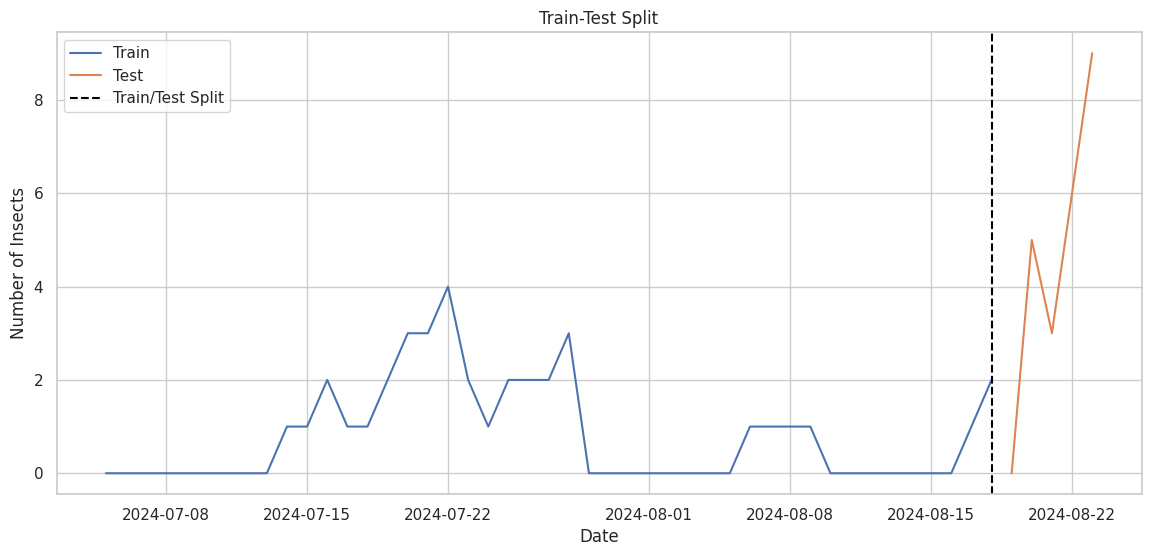

In [16]:
# Optional: visualize the split
plt.figure(figsize=(14, 6))
plt.plot(y_train.index, y_train, label='Train')
plt.plot(y_test.index, y_test, label='Test')
plt.axvline(y_train.index[-1], color='black', linestyle='--', label='Train/Test Split')
plt.title('Train-Test Split')
plt.xlabel('Date')
plt.ylabel('Number of Insects')
plt.legend()
plt.show()

### Fit the SARIMA model

In [17]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Step 1: Fit SARIMA model
model = auto_arima(
    y_train,
    exogenous=X_train,
    seasonal=True,
    m=7,
    d=None,
    D=1,
    start_p=0, max_p=3,   # Range of p values
    start_q=0, max_q=3,   # Range of q values
    start_P=0, max_P=2,   # Seasonal AR order
    start_Q=0, max_Q=2,   # Seasonal MA order
    stepwise=True,
    enforce_stationarity=False,
    enforce_invertibility=False,
    suppress_warnings=True,
    trace=True,           # Print the search process
    error_action='ignore'
)

# Summary of the best model
print(model.summary())

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,1,0)[7] intercept   : AIC=144.925, Time=0.06 sec
 ARIMA(1,0,0)(1,1,0)[7] intercept   : AIC=117.182, Time=0.07 sec
 ARIMA(0,0,1)(0,1,1)[7] intercept   : AIC=inf, Time=0.33 sec
 ARIMA(0,0,0)(0,1,0)[7]             : AIC=143.024, Time=0.02 sec
 ARIMA(1,0,0)(0,1,0)[7] intercept   : AIC=125.508, Time=0.04 sec
 ARIMA(1,0,0)(2,1,0)[7] intercept   : AIC=111.066, Time=0.13 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,0,0)(2,1,1)[7] intercept   : AIC=inf, Time=0.66 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,0,0)(1,1,1)[7] intercept   : AIC=inf, Time=0.33 sec
 ARIMA(0,0,0)(2,1,0)[7] intercept   : AIC=137.802, Time=0.09 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,0,0)(2,1,0)[7] intercept   : AIC=113.019, Time=0.20 sec
 ARIMA(1,0,1)(2,1,0)[7] intercept   : AIC=113.001, Time=0.18 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,0,1)(2,1,0)[7] intercept   : AIC=124.061, Time=0.13 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,0,1)(2,1,0)[7] intercept   : AIC=114.847, Time=0.51 sec
 ARIMA(1,0,0)(2,1,0)[7]             : AIC=109.068, Time=0.12 sec
 ARIMA(1,0,0)(1,1,0)[7]             : AIC=115.380, Time=0.05 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,0,0)(2,1,1)[7]             : AIC=inf, Time=0.46 sec
 ARIMA(1,0,0)(1,1,1)[7]             : AIC=inf, Time=0.17 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,0,0)(2,1,0)[7]             : AIC=136.850, Time=0.06 sec
 ARIMA(2,0,0)(2,1,0)[7]             : AIC=111.019, Time=0.12 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,0,1)(2,1,0)[7]             : AIC=111.001, Time=0.16 sec
 ARIMA(0,0,1)(2,1,0)[7]             : AIC=122.367, Time=0.10 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,0,1)(2,1,0)[7]             : AIC=112.849, Time=0.34 sec

Best model:  ARIMA(1,0,0)(2,1,0)[7]          
Total fit time: 4.345 seconds
                                     SARIMAX Results                                     
Dep. Variable:                                 y   No. Observations:                   45
Model:             SARIMAX(1, 0, 0)x(2, 1, 0, 7)   Log Likelihood                 -50.534
Date:                           Thu, 17 Apr 2025   AIC                            109.068
Time:                                   09:08:02   BIC                            115.619
Sample:                               07-05-2024   HQIC                           111.399
                                    - 08-18-2024                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------

### Forcast by SARIMA model

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


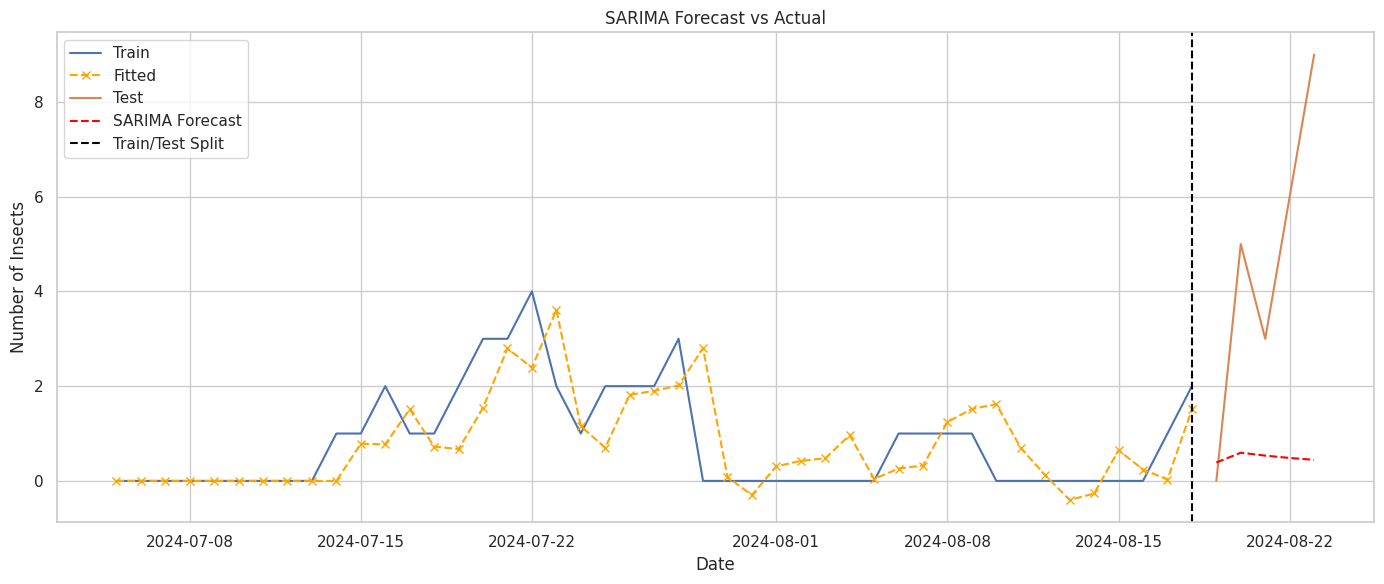

In [18]:
# Step 2: Forecast for the test period
forecast = model.predict(n_periods=len(y_test), exogenous=X_test)
forecast = pd.Series(forecast, index=y_test.index)


# Step 3: Plot forecast vs actual for train and test
plt.figure(figsize=(14, 6))
plt.plot(y_train.index, y_train, label='Train')
plt.plot(y_train.index, model.predict_in_sample(exogenous=X_train), label='Fitted', marker='x', linestyle='--', color='orange')
plt.plot(y_test.index, y_test, label='Test')
plt.plot(forecast.index, forecast, label='SARIMA Forecast', color='red', linestyle='--')
plt.axvline(y_train.index[-1], color='black', linestyle='--', label='Train/Test Split')
plt.title("SARIMA Forecast vs Actual")
plt.xlabel("Date")
plt.ylabel("Number of Insects")
plt.legend()
plt.tight_layout()
plt.show()

### Apply differencing (if needed) and check Stationarity for non_seasonal data

In [19]:
# Function
def handle_nonseasonal_stationarity(series, max_diff=6, verbose=True):
    diff_series = series.copy()
    d = 0

    for i in range(max_diff + 1):
        result = adfuller(diff_series.dropna())
        p_value = result[1]
        if verbose:
            print(f"Non-seasonal differencing d={d}, ADF p-value: {p_value:.4f}")
        if p_value < 0.05:
            if verbose:
                print(f"✅ Stationary after {d} non-seasonal difference(s)\n")
            return diff_series, d
        diff_series = diff_series.diff()
        d += 1

    print(f"⚠️ Series may not be stationary after {max_diff} non-seasonal differences.\n")
    return diff_series, d

### Apply differencing (if needed) and check stationarity for seasonal data

In [20]:
def handle_seasonal_stationarity(series, seasonal_period=7, max_diff=6, verbose=True):
    diff_series = series.copy()
    D = 0

    for i in range(max_diff + 1):
        result = adfuller(diff_series.dropna())
        p_value = result[1]
        if verbose:
            print(f"Seasonal differencing D={D}, ADF p-value: {p_value:.4f}")
        if p_value < 0.05:
            if verbose:
                print(f"✅ Stationary after {D} seasonal difference(s)\n")
            return diff_series, D
        diff_series = diff_series.diff(seasonal_period)
        D += 1

    print(f"⚠️ Series may not be seasonally stationary after {max_diff} seasonal differences.\n")
    return diff_series, D

In [21]:
series = aggregated_df['Number of Insects']

# First handle seasonal stationarity (D)
seasonally_diffed, D = handle_seasonal_stationarity(series, seasonal_period=7)

# Then handle non-seasonal stationarity (d)
final_stationary_series, d = handle_nonseasonal_stationarity(seasonally_diffed)

print(f"Final differencing parameters: d = {d}, D = {D}")

Seasonal differencing D=0, ADF p-value: 0.4040
Seasonal differencing D=1, ADF p-value: 0.9561
Seasonal differencing D=2, ADF p-value: 0.9766
Seasonal differencing D=3, ADF p-value: 0.0039
✅ Stationary after 3 seasonal difference(s)

Non-seasonal differencing d=0, ADF p-value: 0.0039
✅ Stationary after 0 non-seasonal difference(s)

Final differencing parameters: d = 0, D = 3


### Split train and test affter handle non-stationary problem

In [22]:
# Define target and exogenous features
target = 'Number of Insects'

# Choose meteorological features for ARIMAX
exog_features = [
    'New Catches',
    'Event',
    'Average Temperature',
    'Temp_low',
    'Temp_high',
    'Average Humidity',
    'Day Min_temp',
    'Day Max_temp',
    'Day Avg_temp',
    'Day Avg_Humidity',
    'Temp_change',
    # 'Year',
    # 'Month',
    # 'Day',
    # 'Weekday'
]

# Drop NA values due to differencing (if needed)
exogenous_data = aggregated_df[[target] + exog_features].dropna()

# Optional: Check for NaNs in exogenous data
print("\nMissing values in exogenous features:\n")
print(exogenous_data.isnull().sum())


Missing values in exogenous features:

Number of Insects      0
New Catches            0
Event                  0
Average Temperature    0
Temp_low               0
Temp_high              0
Average Humidity       0
Day Min_temp           0
Day Max_temp           0
Day Avg_temp           0
Day Avg_Humidity       0
Temp_change            0
dtype: int64


In [23]:
# Ensure datetime index if not already
exogenous_data.index = pd.to_datetime(exogenous_data.index)

# Split into train and test (90/10 split)
split_index = int(len(exogenous_data) * 0.9)
train = exogenous_data.iloc[:split_index]
test = exogenous_data.iloc[split_index:]

# Define endogenous and exogenous variables
y_train = train[target]
X_train = train[exog_features]
y_test = test[target]
X_test = test[exog_features]

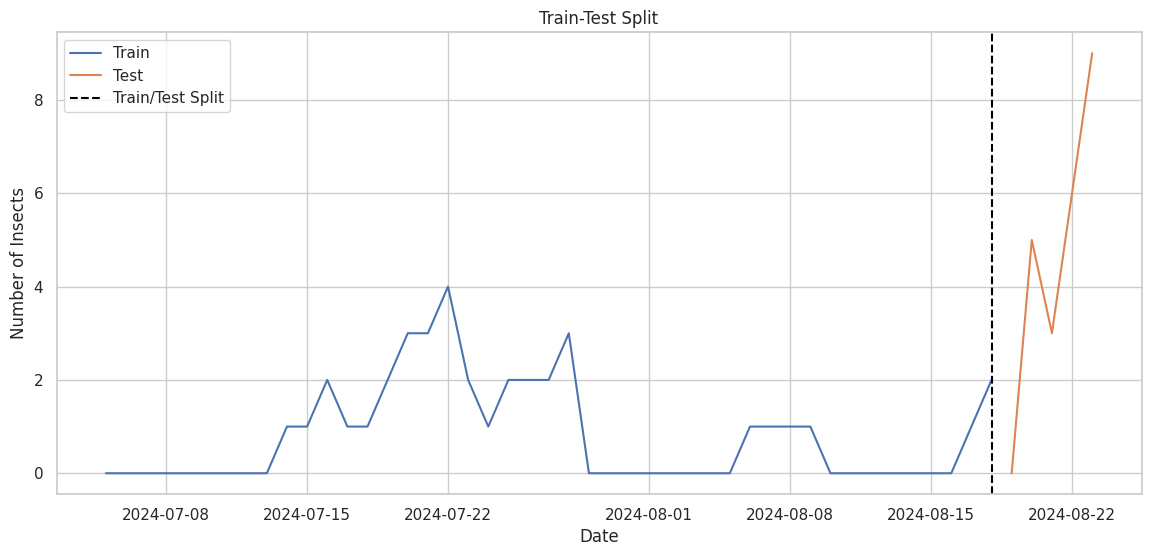

In [24]:
# Optional: visualize the split
plt.figure(figsize=(14, 6))
plt.plot(y_train.index, y_train, label='Train')
plt.plot(y_test.index, y_test, label='Test')
plt.axvline(y_train.index[-1], color='black', linestyle='--', label='Train/Test Split')
plt.title('Train-Test Split')
plt.xlabel('Date')
plt.ylabel('Number of Insects')
plt.legend()
plt.show()

### Fit the SARIMAX model by the new parameters

In [38]:
##############################
# Fit SARIMA model (using SARIMAX with no exogenous variables)
sarimax_model = SARIMAX(
    y_train,
    exgogenous=X_train,
    order=(1, 0, 0),               # (p, d, q) — you can tune p & q manually or use prior auto_arima result
    seasonal_order=(2, 3, 0, 7),   # (P, D, Q, m) — m=7 for weekly seasonality
    enforce_stationarity=False,
    enforce_invertibility=False
)

sarimax_result = sarimax_model.fit(disp=False)
print(sarimax_result.summary())

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['exgogenous']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                                     SARIMAX Results                                     
Dep. Variable:                 Number of Insects   No. Observations:                   45
Model:             SARIMAX(1, 0, 0)x(2, 3, 0, 7)   Log Likelihood                 -16.679
Date:                           Thu, 17 Apr 2025   AIC                             41.358
Time:                                   09:42:52   BIC                             42.147
Sample:                               07-05-2024   HQIC                            39.656
                                    - 08-18-2024                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.1473      0.688      1.667      0.096      -0.202       2.496
ar.S.L7       -1.2155      0.483     -2.518

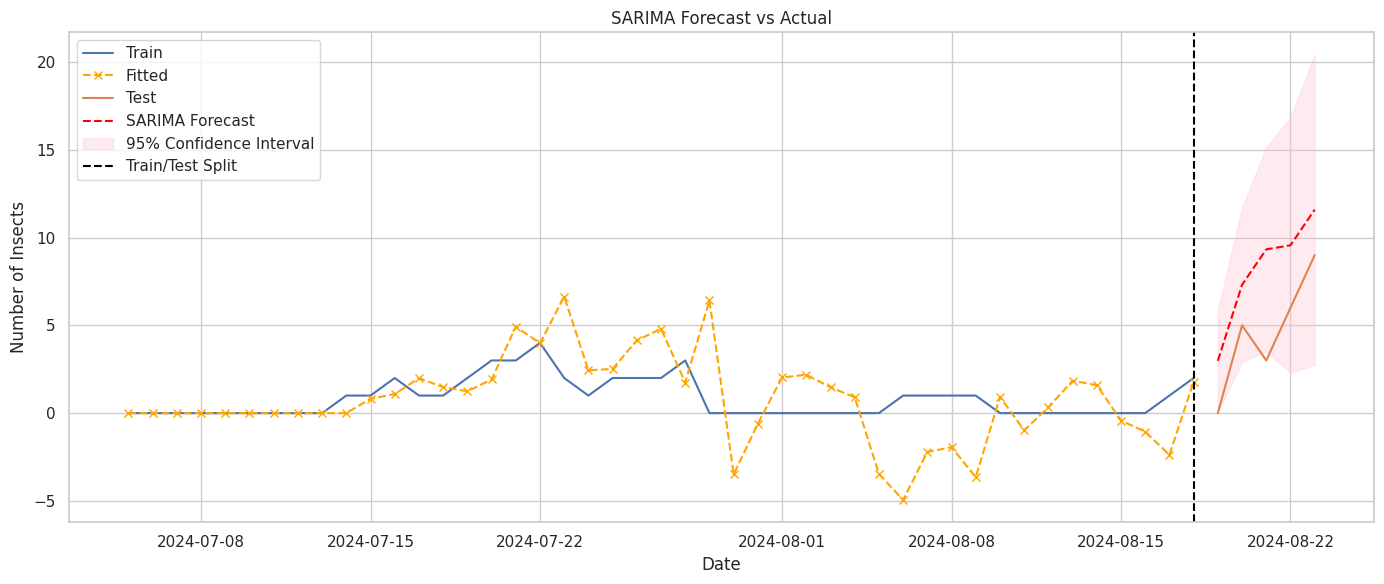

In [39]:
# Forecast for the test period
sarimax_forecast = sarimax_result.get_forecast(steps=len(y_test), exog=X_test)
forecast_mean = sarimax_forecast.predicted_mean
conf_int = sarimax_forecast.conf_int()

# Plot forecast vs actual
plt.figure(figsize=(14, 6))
plt.plot(y_train.index, y_train, label='Train')
plt.plot(y_train.index, sarimax_result.fittedvalues, label='Fitted', marker='x', linestyle='--', color='orange')
plt.plot(y_test.index, y_test, label='Test')
plt.plot(forecast_mean.index, forecast_mean, label='SARIMAX Forecast', color='red', linestyle='--')
plt.fill_between(conf_int.index, conf_int.iloc[:, 0], conf_int.iloc[:, 1], color='pink', alpha=0.3, label='95% Confidence Interval')
plt.axvline(y_train.index[-1], color='black', linestyle='--', label='Train/Test Split')
plt.title("SARIMAX Forecast vs Actual")
plt.xlabel("Date")
plt.ylabel("Number of Insects")
plt.legend()
plt.tight_layout()
plt.show()

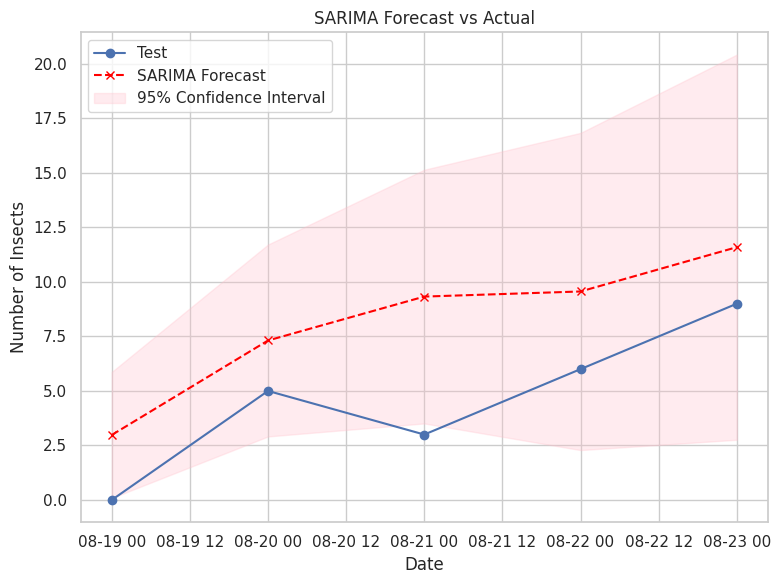

In [33]:
# Plot forecast vs actual
plt.figure(figsize=(8, 6))
plt.plot(y_test.index, y_test, label='Test', marker='o')
plt.plot(forecast_mean.index, forecast_mean, label='SARIMA Forecast', color='red', linestyle='--', marker='x')
plt.fill_between(conf_int.index, conf_int.iloc[:, 0], conf_int.iloc[:, 1], color='pink', alpha=0.3, label='95% Confidence Interval')
plt.title("SARIMA Forecast vs Actual")
plt.xlabel("Date")
plt.ylabel("Number of Insects")
plt.legend()
plt.tight_layout()
plt.show()